## 1. Setup and Data Loading

In [20]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

In [21]:
# Define file paths
BASE_DIR = Path('baseline_results')
LLM_RESULTS_FILE = BASE_DIR / 'llm_results.json'
EVAL_RESULTS_FILE = BASE_DIR / 'evaluation_results_10_combined.json'
TFIDF_BM25_FILE = BASE_DIR / 'tfidf_bm25_lead_results.json'

# Load all results files
print("Loading data files...")

with open(LLM_RESULTS_FILE, 'r') as f:
    llm_results = json.load(f)
print(f"✓ Loaded LLM results: {len(llm_results)} papers")

with open(EVAL_RESULTS_FILE, 'r') as f:
    eval_results = json.load(f)
print(f"✓ Loaded evaluation results: {len(eval_results)} papers")

with open(TFIDF_BM25_FILE, 'r') as f:
    tfidf_bm25_results = json.load(f)
print(f"✓ Loaded TF-IDF/BM25/Lead results: {len(tfidf_bm25_results)} papers")

print("\n" + "="*60)
print("Data loading complete!")
print("="*60)

Loading data files...
✓ Loaded LLM results: 10 papers
✓ Loaded evaluation results: 10 papers
✓ Loaded TF-IDF/BM25/Lead results: 10 papers

Data loading complete!


## 2. Data Consolidation

Consolidate all results into structured DataFrames for analysis.

In [25]:
def create_consolidated_dataframe():
    """
    Create a consolidated DataFrame with all baseline results.
    """
    rows = []
    
    # Process LLM results (gemma3:1b)
    for paper in llm_results:
        paper_id = paper['paper_id']
        if 'gemma3:1b' in paper:
            metrics = paper['gemma3:1b']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'LLM-Gemma3-1B',
                'category': 'LLM-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
    
    # Process evaluation results (embedding-based + other LLMs)
    for paper in eval_results:
        paper_id = paper['paper_id']
        
        # Gemini-2.5-Flash
        if 'gemini-2.5-flash' in paper:
            metrics = paper['gemini-2.5-flash']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Embedding-Gemini-2.5',
                'category': 'Embedding-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
        
        # Llama-3.1-8B
        if 'llama-3.1-8b-instant' in paper:
            metrics = paper['llama-3.1-8b-instant']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Embedding-Llama-3.1',
                'category': 'Embedding-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
        
        # LED
        if 'led' in paper:
            metrics = paper['led']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Embedding-LED',
                'category': 'Embedding-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
    
    # Process TF-IDF/BM25/Lead-N results
    for paper_id, content in tfidf_bm25_results.items():
        scores = content['score']
        lead_n = scores['lead_n']

        # TF-IDF
        if 'TF-IDF' in scores:
            tfidf = scores['TF-IDF']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'TF-IDF',
                'category': 'Stats-Based',
                'rouge1': tfidf.get('rouge1', np.nan),
                'rouge2': tfidf.get('rouge2', np.nan),
                'rougeL': tfidf.get('rougeL', np.nan),
                'bertscore_f1': tfidf.get('bertscore_f1', np.nan),
            })
        
        # BM25
        if 'BM25' in scores:
            bm25 = scores['BM25']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'BM25',
                'category': 'Stats-Based',
                'rouge1': bm25.get('rouge1', np.nan),
                'rouge2': bm25.get('rouge2', np.nan),
                'rougeL': bm25.get('rougeL', np.nan),
                'bertscore_f1': bm25.get('bertscore_f1', np.nan),
            })
        
        # Lead-N
        if 'lead_n' in scores:
            lead_n = scores['lead_n']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Lead-N',
                'category': 'Rules-Based',
                'rouge1': lead_n.get('rouge1', np.nan),
                'rouge2': lead_n.get('rouge2', np.nan),
                'rougeL': lead_n.get('rougeL', np.nan),
                'bertscore_f1': lead_n.get('bertscore_f1', np.nan),
            })

        if 'lead_n_by_section' in scores:
            lead_n_by_section = scores['lead_n_by_section']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Lead-N-By-Section',
                'category': 'Rules-Based',
                'rouge1': lead_n_by_section.get('rouge1', np.nan),
                'rouge2': lead_n_by_section.get('rouge2', np.nan),
                'rougeL': lead_n_by_section.get('rougeL', np.nan),
                'bertscore_f1': lead_n_by_section.get('bertscore_f1', np.nan),
            })
    
    df = pd.DataFrame(rows)
    return df

# Create consolidated DataFrame
df_consolidated = create_consolidated_dataframe()

print(f"✓ Consolidated DataFrame created with {len(df_consolidated)} entries")
print(f"\nBaselines included: {df_consolidated['baseline'].unique().tolist()}")
print(f"\nCategories: {df_consolidated['category'].unique().tolist()}")

✓ Consolidated DataFrame created with 80 entries

Baselines included: ['LLM-Gemma3-1B', 'Embedding-Gemini-2.5', 'Embedding-Llama-3.1', 'Embedding-LED', 'TF-IDF', 'BM25', 'Lead-N', 'Lead-N-By-Section']

Categories: ['LLM-Based', 'Embedding-Based', 'Stats-Based', 'Rules-Based']


In [26]:
# Display first few rows
print("\nFirst 10 rows of consolidated data:")
df_consolidated


First 10 rows of consolidated data:


,paper_id,baseline,category,rouge1,rouge2,rougeL,bertscore_f1
0,2511.21398v1,LLM-Gemma3-1B,LLM-Based,0.4169,0.0000,0.1694,0.6608
1,2511.21444v1,LLM-Gemma3-1B,LLM-Based,0.3631,0.0000,0.1600,0.6087
2,2511.21460v1,LLM-Gemma3-1B,LLM-Based,0.4299,0.0000,0.1620,0.6448
3,2511.21471v1,LLM-Gemma3-1B,LLM-Based,0.3537,0.0000,0.1801,0.6063
4,2511.21522v1,LLM-Gemma3-1B,LLM-Based,0.2980,0.0000,0.1804,0.5986
5,2511.21569v1,LLM-Gemma3-1B,LLM-Based,0.1744,0.0000,0.1128,0.5627
6,2511.21570v1,LLM-Gemma3-1B,LLM-Based,0.2437,0.0000,0.1290,0.6054
7,2511.21591v1,LLM-Gemma3-1B,LLM-Based,0.3357,0.0000,0.1888,0.5941
8,2511.21636v1,LLM-Gemma3-1B,LLM-Based,0.3010,0.0000,0.1538,0.5590
9,2511.21678v1,LLM-Gemma3-1B,LLM-Based,0.3614,0.0000,0.1682,0.6169


In [27]:
# Data quality check
print("Data Quality Summary:")
print("="*60)
print(f"Total entries: {len(df_consolidated)}")
print(f"Unique papers: {df_consolidated['paper_id'].nunique()}")
print(f"\nMissing values per column:")
print(df_consolidated.isnull().sum())
print(f"\nBaseline distribution:")
print(df_consolidated['baseline'].value_counts())

Data Quality Summary:
Total entries: 80
Unique papers: 10

Missing values per column:
paper_id        0
baseline        0
category        0
rouge1          0
rouge2          0
rougeL          0
bertscore_f1    0
dtype: int64

Baseline distribution:
baseline
LLM-Gemma3-1B           10
Embedding-Gemini-2.5    10
Embedding-Llama-3.1     10
Embedding-LED           10
TF-IDF                  10
BM25                    10
Lead-N                  10
Lead-N-By-Section       10
Name: count, dtype: int64


## 3. Descriptive Statistics

In [29]:
# Calculate summary statistics by baseline
summary_stats = df_consolidated.groupby('baseline')[[
    'rouge1', 'rouge2', 'rougeL', 'bertscore_f1',
]].agg(['mean', 'std', 'min', 'max', 'median'])

print("\n" + "="*80)
print("SUMMARY STATISTICS BY BASELINE")
print("="*80)
summary_stats


SUMMARY STATISTICS BY BASELINE


rouge1                             rouge2                \
                       mean    std    min    max median   mean    std    min   
baseline                                                                       
BM25                 0.3178 0.1218 0.1430 0.4787 0.3427 0.0701 0.0463 0.0040   
Embedding-Gemini-2.5 0.4106 0.1062 0.1507 0.5167 0.4412 0.1049 0.0370 0.0276   
Embedding-LED        0.3408 0.1041 0.0980 0.4482 0.3527 0.0788 0.0368 0.0123   
Embedding-Llama-3.1  0.3897 0.0880 0.1897 0.4692 0.4168 0.0969 0.0373 0.0239   
LLM-Gemma3-1B        0.3278 0.0772 0.1744 0.4299 0.3447 0.0000 0.0000 0.0000   
Lead-N               0.2955 0.0493 0.1987 0.3578 0.3108 0.0544 0.0181 0.0240   
Lead-N-By-Section    0.3344 0.0993 0.0958 0.4160 0.3757 0.0885 0.0292 0.0192   
TF-IDF               0.3618 0.0721 0.2105 0.4650 0.3671 0.0918 0.0266 0.0357   

                                   rougeL                              \
                        max median   mean    std    min    max median   
baseline                                                                
BM25                 0.1316 0.0840 0.1455 0.0462 0.0644 0.2150 0.1488   
Embedding-Gemini-2.5 0.1464 0.1095 0.1861 0.0602 0.0685 0.2750 0.1921   
Embedding-LED        0.1257 0.0865 0.1463 0.0450 0.0490 0.2129 0.1584   
Embedding-Llama-3.1  0.1397 0.1031 0.1839 0.0405 0.1028 0.2386 0.1921   
LLM-Gemma3-1B        0.0000 0.0000 0.1605 0.0236 0.1128 0.1888 0.1651   
Lead-N               0.0772 0.0554 0.1398 0.0217 0.1105 0.1725 0.1393   
Lead-N-By-Section    0.1206 0.0911 0.1573 0.0507 0.0465 0.2080 0.1687   
TF-IDF               0.1278 0.0996 0.1678 0.0323 0.1147 0.2140 0.1746   

                     bertscore_f1                              
                             mean    std    min    max median  
baseline                                                       
BM25                       0.7441 0.0767 0.6160 0.8202 0.7709  
Embedding-Gemini-2.5       0.7886 0.0351 0.7229 0.8348 0.7935  
Embedding-LED              0.7894 0.0296 0.7322 0.8251 0.7973  
Embedding-Llama-3.1        0.7898 0.0297 0.7198 0.8116 0.8020  
LLM-Gemma3-1B              0.6057 0.0315 0.5590 0.6608 0.6059  
Lead-N                     0.7652 0.0220 0.7297 0.8002 0.7605  
Lead-N-By-Section          0.7845 0.0208 0.7398 0.8070 0.7887  
TF-IDF                     0.7817 0.0466 0.6591 0.8214 0.7876

In [30]:
# Calculate summary statistics by category
category_stats = df_consolidated.groupby('category')[[
    'rouge1', 'rouge2', 'rougeL', 'bertscore_f1'
]].agg(['mean', 'std'])

print("\n" + "="*80)
print("SUMMARY STATISTICS BY CATEGORY")
print("="*80)
category_stats


SUMMARY STATISTICS BY CATEGORY


rouge1        rouge2        rougeL        bertscore_f1       
                  mean    std   mean    std   mean    std         mean    std
category                                                                     
Embedding-Based 0.3804 0.1007 0.0936 0.0374 0.1721 0.0510       0.7893 0.0305
LLM-Based       0.3278 0.0772 0.0000 0.0000 0.1605 0.0236       0.6057 0.0315
Rules-Based     0.3149 0.0789 0.0715 0.0294 0.1486 0.0390       0.7749 0.0231
Stats-Based     0.3398 0.1000 0.0809 0.0384 0.1567 0.0404       0.7629 0.0647

## 4. Comparative Visualizations

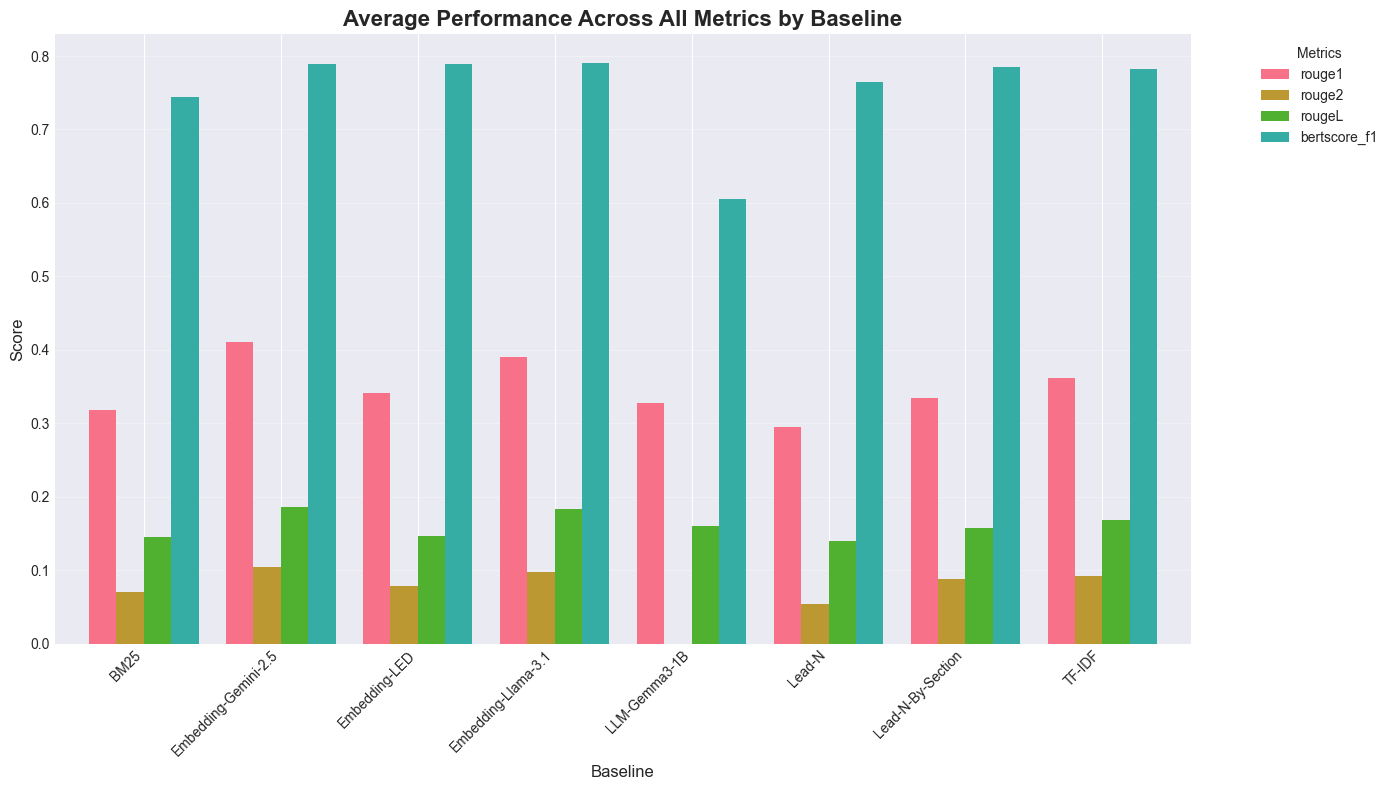

In [31]:
# Average performance across all metrics by baseline
metrics = ['rouge1', 'rouge2', 'rougeL', 'bertscore_f1']
avg_performance = df_consolidated.groupby('baseline')[metrics].mean()

fig, ax = plt.subplots(figsize=(14, 8))
avg_performance.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Performance Across All Metrics by Baseline', fontsize=16, fontweight='bold')
ax.set_xlabel('Baseline', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

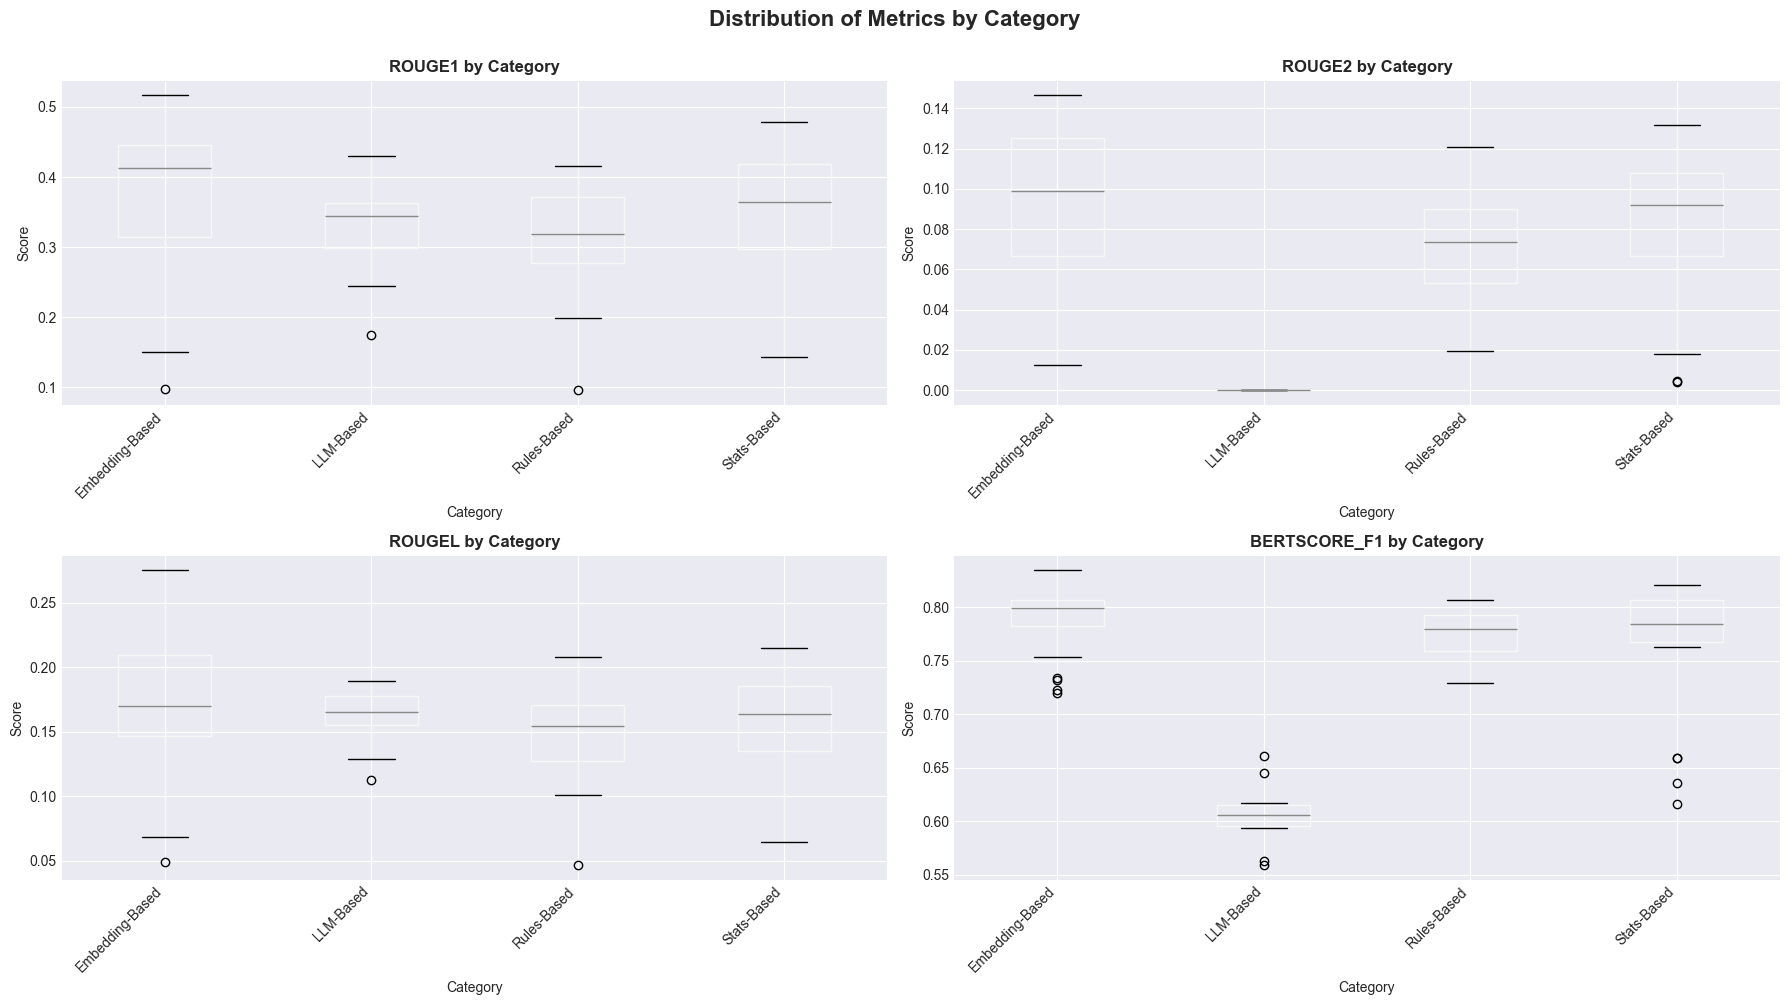

In [41]:
# Box plots for each metric
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    df_consolidated.boxplot(column=metric, by='category', ax=ax)
    ax.set_title(f'{metric.upper()} by Category', fontsize=12, fontweight='bold')
    ax.set_xlabel('Category', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

# Remove the last empty subplot
# fig.delaxes(axes[5])

plt.suptitle('Distribution of Metrics by Category', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

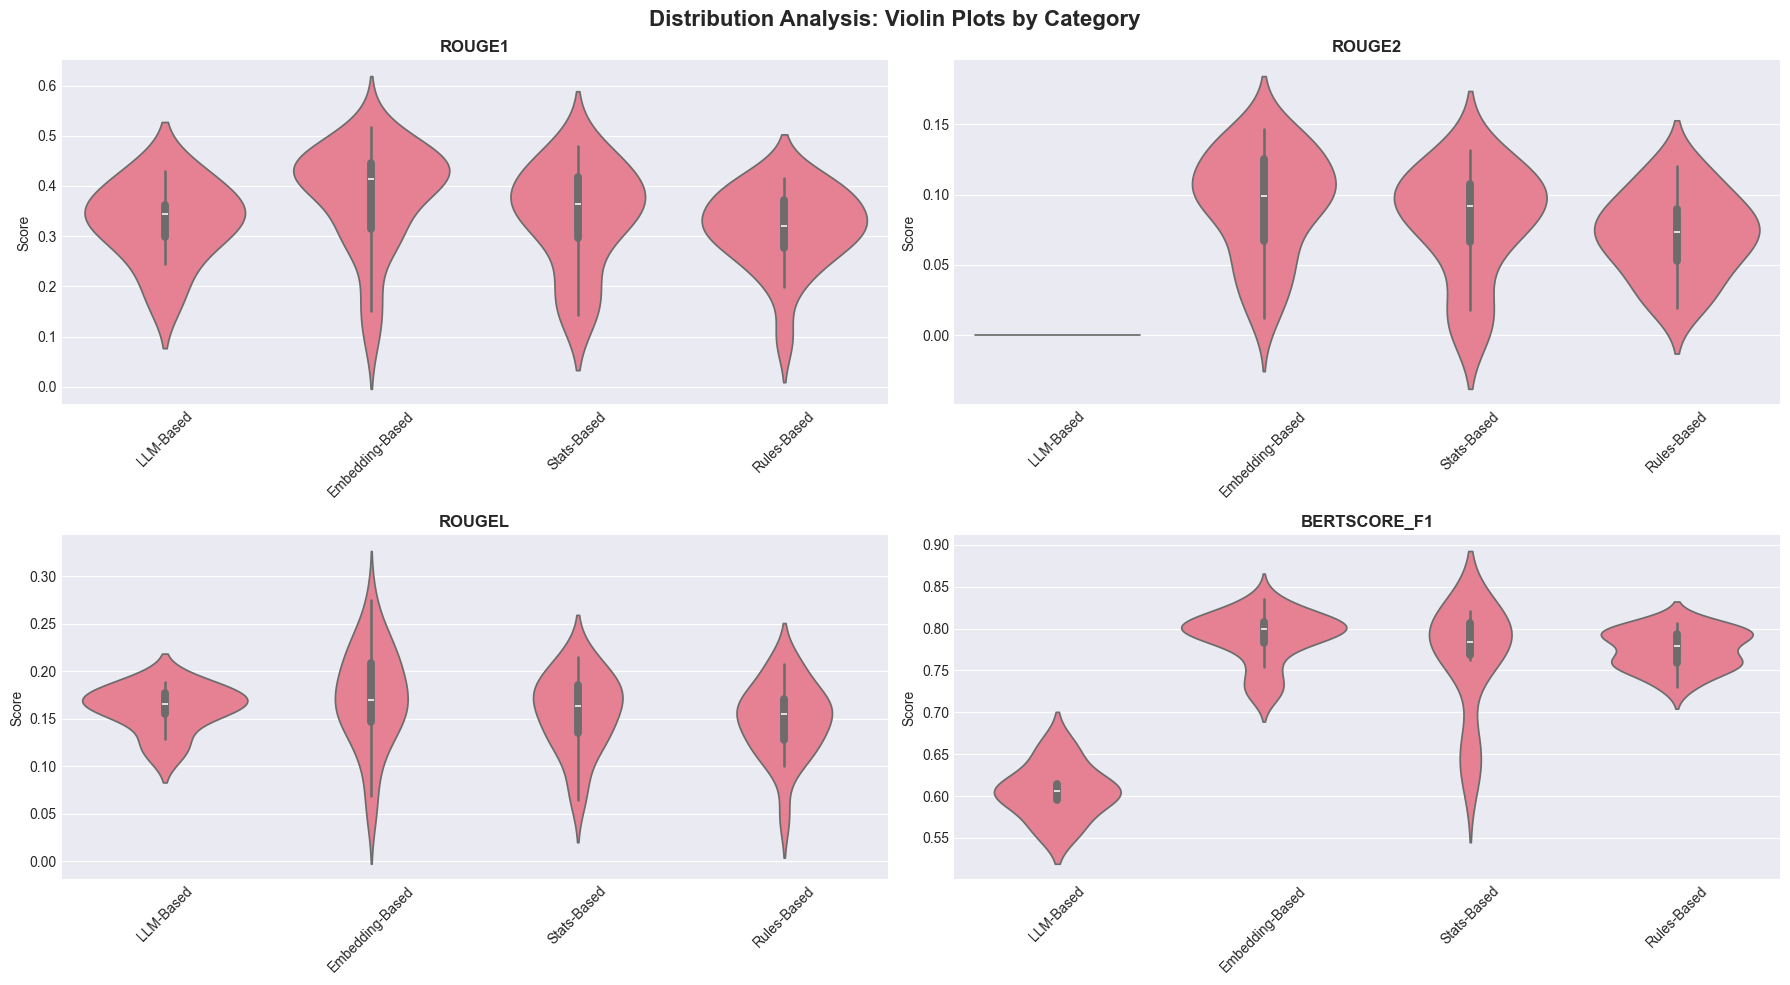

In [40]:
# Violin plots comparing all baselines
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sns.violinplot(data=df_consolidated, x='category', y=metric, ax=ax, inner='box')
    ax.set_title(f'{metric.upper()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Score', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

# Remove the last empty subplot
# fig.delaxes(axes[3])

plt.suptitle('Distribution Analysis: Violin Plots by Category', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

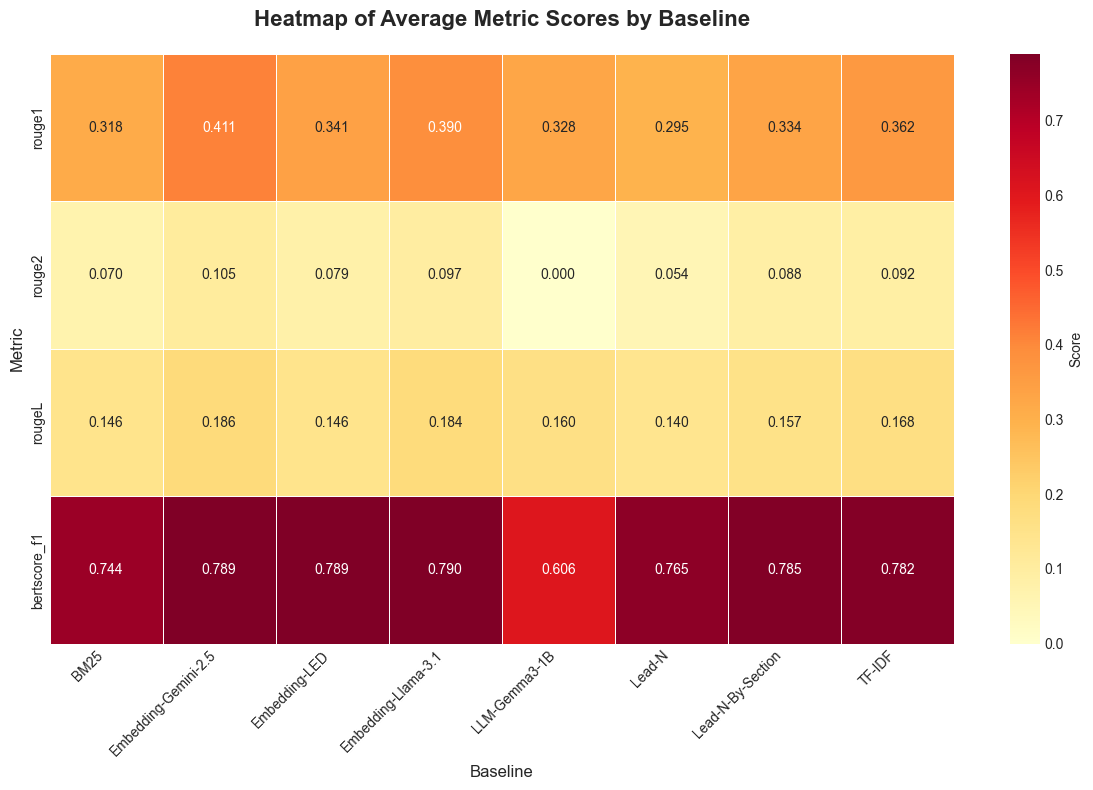

In [37]:
# Heatmap of average scores
pivot_data = df_consolidated.groupby('baseline')[metrics].mean()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data.T, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
ax.set_title('Heatmap of Average Metric Scores by Baseline', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Baseline', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Ranking Analysis


OVERALL BASELINE RANKINGS (by average score across all metrics)
               baseline  average_score
0  Embedding-Gemini-2.5         0.3726
1   Embedding-Llama-3.1         0.3651
2                TF-IDF         0.3508
3     Lead-N-By-Section         0.3412
4         Embedding-LED         0.3388
5                  BM25         0.3194
6                Lead-N         0.3137
7         LLM-Gemma3-1B         0.2735


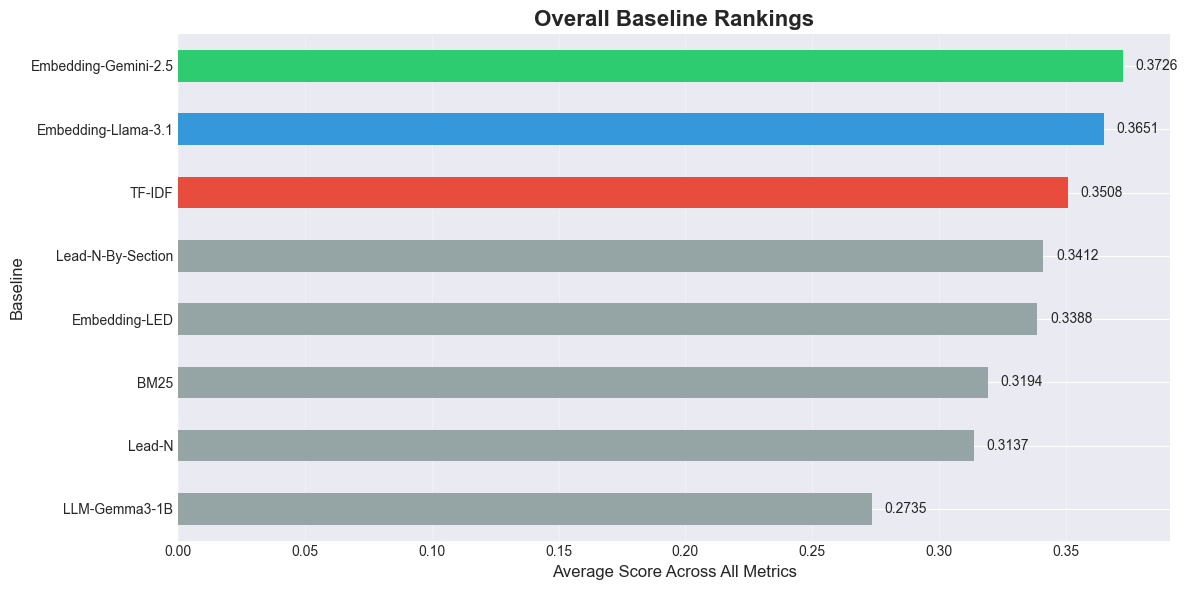

In [42]:
# Calculate overall ranking based on average across all metrics
baseline_rankings = df_consolidated.groupby('baseline')[metrics].mean()
baseline_rankings['average_score'] = baseline_rankings.mean(axis=1)
baseline_rankings = baseline_rankings.sort_values('average_score', ascending=False)

print("\n" + "="*80)
print("OVERALL BASELINE RANKINGS (by average score across all metrics)")
print("="*80)
print(baseline_rankings[['average_score']].reset_index())

# Visualize rankings
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2ecc71' if i == 0 else '#3498db' if i == 1 else '#e74c3c' if i == 2 else '#95a5a6' 
          for i in range(len(baseline_rankings))]
baseline_rankings['average_score'].plot(kind='barh', ax=ax, color=colors)
ax.set_title('Overall Baseline Rankings', fontsize=16, fontweight='bold')
ax.set_xlabel('Average Score Across All Metrics', fontsize=12)
ax.set_ylabel('Baseline', fontsize=12)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(baseline_rankings['average_score']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [43]:
# Ranking by individual metrics
print("\n" + "="*80)
print("TOP 3 BASELINES PER METRIC")
print("="*80)

for metric in metrics:
    print(f"\n{metric.upper()}:")
    top3 = df_consolidated.groupby('baseline')[metric].mean().sort_values(ascending=False).head(3)
    for rank, (baseline, score) in enumerate(top3.items(), 1):
        print(f"  {rank}. {baseline}: {score:.4f}")


TOP 3 BASELINES PER METRIC

ROUGE1:
  1. Embedding-Gemini-2.5: 0.4106
  2. Embedding-Llama-3.1: 0.3897
  3. TF-IDF: 0.3618

ROUGE2:
  1. Embedding-Gemini-2.5: 0.1049
  2. Embedding-Llama-3.1: 0.0969
  3. TF-IDF: 0.0918

ROUGEL:
  1. Embedding-Gemini-2.5: 0.1861
  2. Embedding-Llama-3.1: 0.1839
  3. TF-IDF: 0.1678

BERTSCORE_F1:
  1. Embedding-Llama-3.1: 0.7898
  2. Embedding-LED: 0.7894
  3. Embedding-Gemini-2.5: 0.7886


## 6. Statistical Significance Testing

In [44]:
# Perform pairwise t-tests between top baselines
def perform_pairwise_ttests(df, metric, baseline1, baseline2):
    """
    Perform paired t-test between two baselines for a specific metric.
    """
    # Get common papers for both baselines
    data1 = df[df['baseline'] == baseline1].set_index('paper_id')[metric]
    data2 = df[df['baseline'] == baseline2].set_index('paper_id')[metric]
    
    # Find common papers
    common_papers = data1.index.intersection(data2.index)
    
    if len(common_papers) < 2:
        return None, None, 0
    
    data1_common = data1.loc[common_papers]
    data2_common = data2.loc[common_papers]
    
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(data1_common, data2_common)
    
    return t_stat, p_value, len(common_papers)

# Get top 3 baselines
top_3_baselines = baseline_rankings.head(3).index.tolist()

print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING (Paired t-tests)")
print("="*80)
print(f"\nComparing top 3 baselines: {', '.join(top_3_baselines)}")
print("\nResults (p < 0.05 indicates statistical significance):")
print("="*80)

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-" * 60)
    
    for i, baseline1 in enumerate(top_3_baselines):
        for baseline2 in top_3_baselines[i+1:]:
            t_stat, p_value, n_samples = perform_pairwise_ttests(
                df_consolidated, metric, baseline1, baseline2
            )
            
            if p_value is not None:
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                print(f"  {baseline1} vs {baseline2}:")
                print(f"    t-statistic: {t_stat:.4f}, p-value: {p_value:.4f} {significance} (n={n_samples})")


STATISTICAL SIGNIFICANCE TESTING (Paired t-tests)

Comparing top 3 baselines: Embedding-Gemini-2.5, Embedding-Llama-3.1, TF-IDF

Results (p < 0.05 indicates statistical significance):

ROUGE1:
------------------------------------------------------------
  Embedding-Gemini-2.5 vs Embedding-Llama-3.1:
    t-statistic: 1.7170, p-value: 0.1201 ns (n=10)
  Embedding-Gemini-2.5 vs TF-IDF:
    t-statistic: 1.9099, p-value: 0.0885 ns (n=10)
  Embedding-Llama-3.1 vs TF-IDF:
    t-statistic: 1.2108, p-value: 0.2568 ns (n=10)

ROUGE2:
------------------------------------------------------------
  Embedding-Gemini-2.5 vs Embedding-Llama-3.1:
    t-statistic: 2.1650, p-value: 0.0586 ns (n=10)
  Embedding-Gemini-2.5 vs TF-IDF:
    t-statistic: 1.1832, p-value: 0.2671 ns (n=10)
  Embedding-Llama-3.1 vs TF-IDF:
    t-statistic: 0.4191, p-value: 0.6849 ns (n=10)

ROUGEL:
------------------------------------------------------------
  Embedding-Gemini-2.5 vs Embedding-Llama-3.1:
    t-statistic: 0.1957,

## 7. Category-wise Comparison

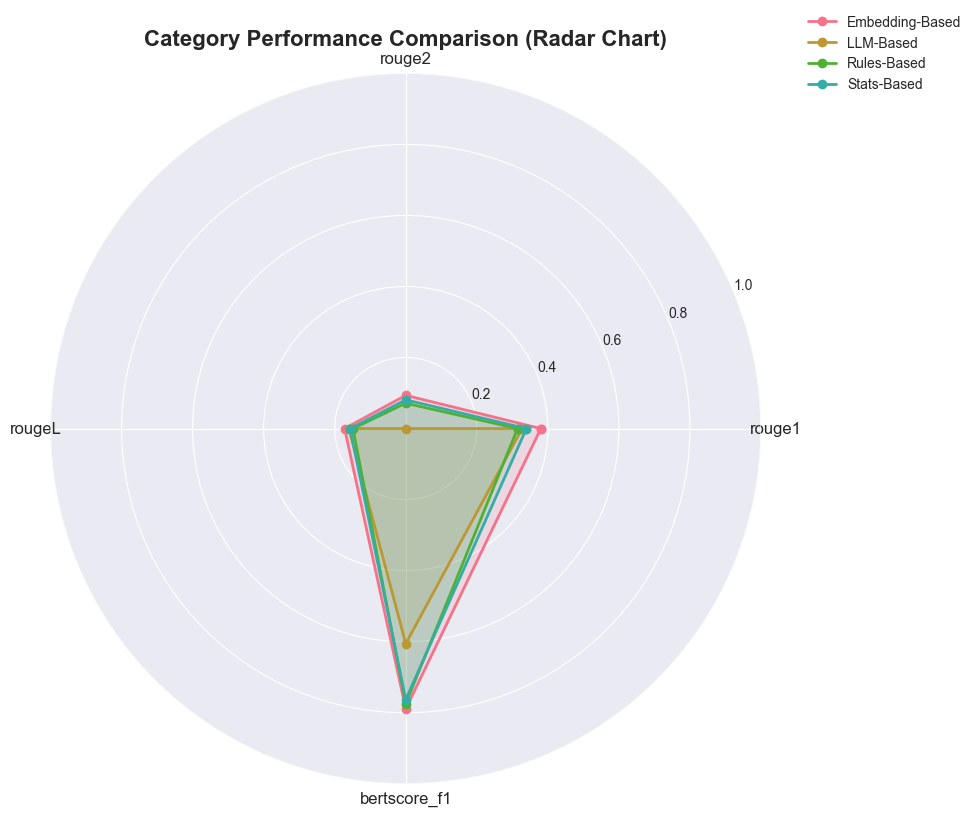

In [45]:
# Compare categories using radar charts
from math import pi

category_means = df_consolidated.groupby('category')[metrics].mean()

# Number of variables
categories = list(category_means.index)
N = len(metrics)

# Angle of each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for category in categories:
    values = category_means.loc[category].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=category)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, size=12)
ax.set_ylim(0, 1)
ax.set_title('Category Performance Comparison (Radar Chart)', 
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

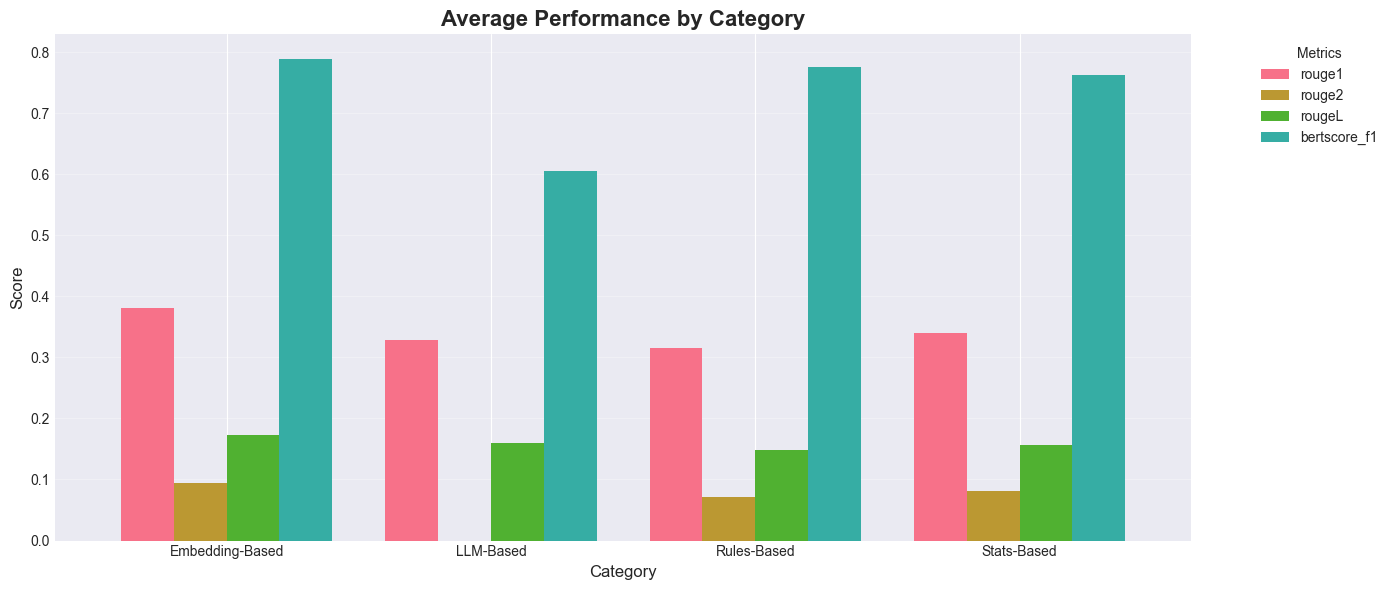

In [46]:
# Category comparison - grouped bar chart
category_comparison = df_consolidated.groupby('category')[metrics].mean()

fig, ax = plt.subplots(figsize=(14, 6))
category_comparison.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Performance by Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Key Findings and Insights

In [19]:
# Generate comprehensive summary
print("\n" + "="*80)
print("KEY FINDINGS AND INSIGHTS")
print("="*80)

# Best overall baseline
best_overall = baseline_rankings.index[0]
best_overall_score = baseline_rankings.iloc[0]['average_score']
print(f"\n1. BEST OVERALL BASELINE: {best_overall}")
print(f"   Average score across all metrics: {best_overall_score:.4f}")

# Best by category
print(f"\n2. BEST BASELINE BY CATEGORY:")
for category in df_consolidated['category'].unique():
    cat_data = df_consolidated[df_consolidated['category'] == category]
    best_in_category = cat_data.groupby('baseline')[metrics].mean().mean(axis=1).idxmax()
    best_score = cat_data.groupby('baseline')[metrics].mean().mean(axis=1).max()
    print(f"   {category}: {best_in_category} ({best_score:.4f})")

# Best by individual metrics
print(f"\n3. BEST BASELINE BY METRIC:")
for metric in metrics:
    best_for_metric = df_consolidated.groupby('baseline')[metric].mean().idxmax()
    best_metric_score = df_consolidated.groupby('baseline')[metric].mean().max()
    print(f"   {metric.upper()}: {best_for_metric} ({best_metric_score:.4f})")

# Performance spread
print(f"\n4. PERFORMANCE VARIABILITY:")
for metric in metrics:
    metric_range = df_consolidated[metric].max() - df_consolidated[metric].min()
    metric_std = df_consolidated[metric].std()
    print(f"   {metric.upper()}: range = {metric_range:.4f}, std = {metric_std:.4f}")

print("\n" + "="*80)


KEY FINDINGS AND INSIGHTS

1. BEST OVERALL BASELINE: Embedding-Gemini-2.5
   Average score across all metrics: 0.4530

2. BEST BASELINE BY CATEGORY:
   LLM-Based: LLM-Gemma3-1B (0.3703)
   Embedding-Based: Embedding-Gemini-2.5 (0.4530)
   Stats-Based: TF-IDF (0.3508)
   Rules-Based: Lead-N (0.3275)

3. BEST BASELINE BY METRIC:
   ROUGE1: Embedding-Gemini-2.5 (0.4106)
   ROUGE2: Embedding-Gemini-2.5 (0.1049)
   ROUGEL: Embedding-Gemini-2.5 (0.1861)
   BERTSCORE_F1: Embedding-Llama-3.1 (0.7898)
   SIMILARITY_TO_ABSTRACT: Embedding-Gemini-2.5 (0.7748)

4. PERFORMANCE VARIABILITY:
   ROUGE1: range = 0.4209, std = 0.0951
   ROUGE2: range = 0.1464, std = 0.0439
   ROUGEL: range = 0.2285, std = 0.0432
   BERTSCORE_F1: range = 0.2758, std = 0.0705
   SIMILARITY_TO_ABSTRACT: range = 0.3327, std = 0.0924

